## 简介：
数据集notMNIST，和MNIST不同的是它是一个各种形态的字母的数据集合，总共有a~j 10个字母组成

![notMnist数据集](./picture/notMnist.png "notMnist数据集")


### 加载相关包

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

In [2]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' %
              (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print(data_folders)
    return data_folders


train_folders = maybe_extract('notMNIST_large.tar.gz')
test_folders = maybe_extract('notMNIST_small.tar.gz')

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


显示图片样本

In [3]:
display(Image(filename="notMNIST_small/C/QmVlc2tuZWVzQy5vdGY=.png"))

## problem1
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---
Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

In [8]:
image_size = 28  # iPixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)

    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - \
                          pixel_depth / 2) / pixel_depth

            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' %
                                str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file,
                  ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                        (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset


def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names


train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

## problem2
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

(52911, 28, 28)


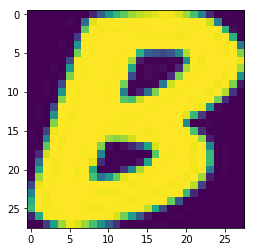

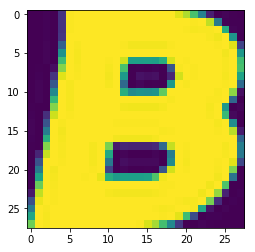

In [40]:
with open('/home/l/桌面/notMNIST/notMNIST_large/B.pickle','rb') as pk_f:
    data_b = pickle.load(pk_f)
print(data_b.shape)
for i in range(0,1000,500):
    pic = data_b[i,:,:]
    plt.imshow(pic)
    plt.show()

## Problem 3_1
Another check: we expect the data to be balanced across classes. Verify that.

In [39]:
file_path = "/home/l/桌面/notMNIST/notMNIST_large/{0}.pickle"

for name in "ABCDEFGHIJ":
    with open(file_path.format(name), 'rb') as pk_f:
        data = pickle.load(pk_f)
        print(data.shape)

(52909, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52911, 28, 28)


## Problem 3_2
Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning